In [81]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import bead_utils as bu
from natsort import natsorted
import glob, os

In [82]:
## basic parameters similar to our resonantors

Fs = 10e3 ## sampling rate [Hz]
omega0 = 2*np.pi*35 ## Hz
gamma = 2*np.pi*3 ## Hz
p0 = 200*5.3e-22 ## kg*m/s = 1 MeV/c
kgms_to_MeV = 5.3e-22
m = 2.5e-14 ## 3 um sphere mass, kg
T = 10 ## period
e_charge = 1.6e-19 ## electron charge, C

omega1 = np.sqrt(omega0**2 - gamma**2)

amp = p0/(m*omega1)
tvec = np.arange(0, T, 1/Fs)
t0 = T/2

In [83]:
## function to deconvolve the transfer function to get a force
def reconstructed_force(x, title=""):
    xtilde = np.fft.rfft(x)
    fvec = np.fft.rfftfreq(len(x), 1/Fs)
    omega_vec = 2*np.pi*fvec

    Ftilde = m*xtilde*(omega0**2 - omega_vec**2 - 1j*gamma*omega_vec)

    F = np.fft.irfft(Ftilde)
    gpts = ((tvec-t0) > -1) & ((tvec-t0) < 1) ## window to integrate impulse over
    impulse_amplitude = np.trapz(F[gpts], x=tvec[gpts])
    print("Integrated impulse amplitude: %.1e [kg m/s], %.1f [MeV]"%(impulse_amplitude, impulse_amplitude/kgms_to_MeV))


    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(tvec-t0, x)
    plt.xlim(-0.5,0.5)
    plt.ylabel("Position [m]")

    plt.subplot(2,1,2)
    plt.plot(tvec-t0, F, label="Integral = %.1f [MeV]"%(impulse_amplitude/kgms_to_MeV))
    plt.xlim(-0.5,0.5)
    offset = 0.1*np.max(np.abs(F[gpts]))
    plt.ylim(np.min(F[gpts])-offset, np.max(F[gpts])+offset)
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.legend()
    plt.suptitle(title)
    plt.show()

    return F, impulse_amplitude

Integrated impulse amplitude: 1.1e-19 [kg m/s], 200.0 [MeV]


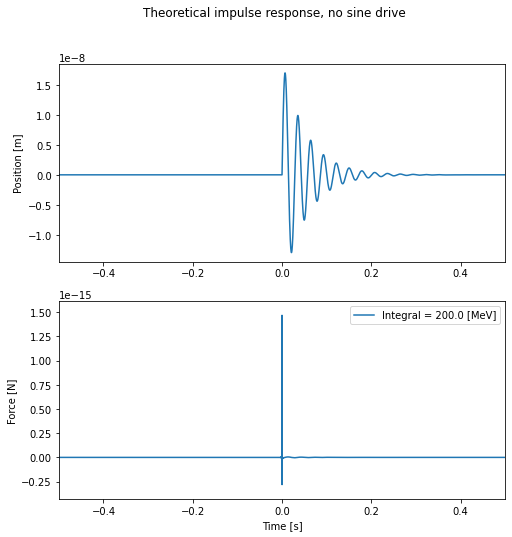

In [84]:
## show we can reconstruct a simple impulse as expected 
x = amp*np.exp(-gamma*(tvec-t0))*(np.sin(omega1*(tvec-t0)))
x[tvec < t0] = 0

F, impulse_amplitude = reconstructed_force(x, title="Theoretical impulse response, no sine drive")

In [85]:
def reconstructed_position(Ftime, title=""):
    Ftilde = np.fft.rfft(Ftime)
    
    fvec = np.fft.rfftfreq(len(Ftime), 1/Fs)
    omega_vec = 2*np.pi*fvec

    xtilde = Ftilde/(m*(omega0**2 - omega_vec**2 + 1j*gamma*omega_vec))
    x = np.fft.irfft(xtilde)

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(tvec-t0, x)
    plt.xlim(-0.5,0.5)
    plt.ylabel("Position [m]")

    plt.subplot(2,1,1)
    plt.plot(tvec-t0, Ftime)
    plt.xlim(-0.5,0.5)
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.suptitle(title)
    plt.show()

    return x

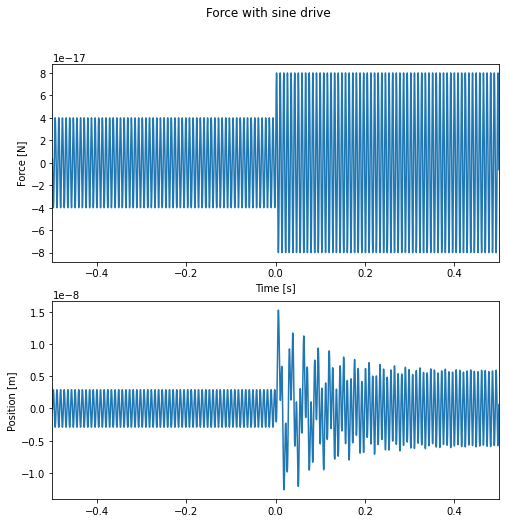

In [86]:
## now let's go the other way -- make a force and reconstruct the time domain from it
fdrive = 123 ## Drive freq in Hz
omega_drive = 2*np.pi*fdrive
Vdrive = 10 ## voltage drive amplitude [V]
d = 4e-2 ## electrode separation [m]

step_function = np.ones_like(tvec)
step_function[tvec > t0] = 2

Ftime = (e_charge*Vdrive/d)*np.sin(omega_drive*tvec)*step_function

x = reconstructed_position(Ftime, title="Force with sine drive")


Integrated impulse amplitude: -4.1e-22 [kg m/s], -0.8 [MeV]


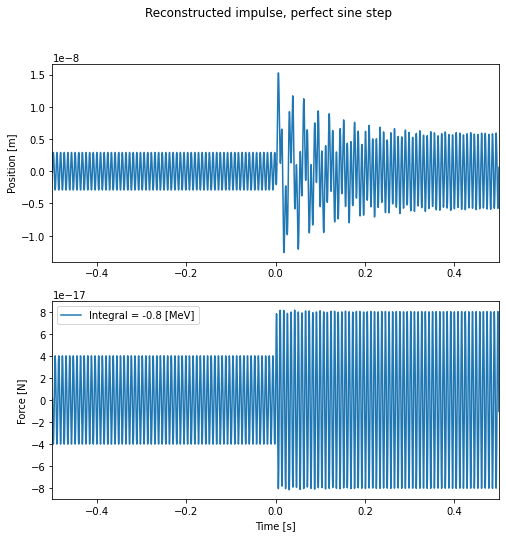

In [87]:
## now try various reconstructions

## no filter
F, impulse_amplitude = reconstructed_force(x, title="Reconstructed impulse, perfect sine step")

Integrated impulse amplitude: 5.2e-20 [kg m/s], 97.6 [MeV]


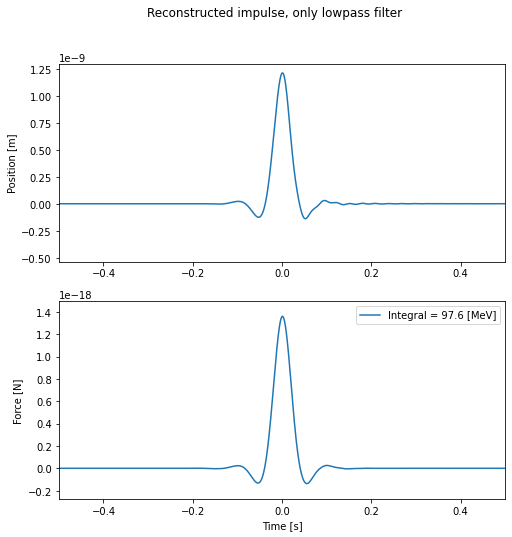

In [88]:
## simple low pass filter
ffilt = 50
b, a = sp.butter(3, ffilt/(2*Fs), btype="lowpass")
xfilt = sp.filtfilt(b,a,x)

F, impulse_amplitude = reconstructed_force(xfilt, "Reconstructed impulse, only lowpass filter")

In [89]:
def correlation_recon(x):
    tt = np.arange(-0.5,0.5,1/Fs)
    template_x = np.exp(-gamma*tt)*(np.sin(omega1*tt))
    template_x[tt < 0] = 0

    corr_out = sp.correlate(x,template_x,mode='same')/np.sum(template_x**2)

    return corr_out * (m*omega1)/kgms_to_MeV

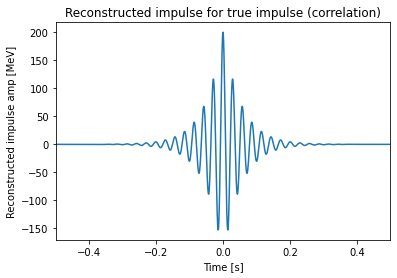

In [90]:
## Double check this works as expected with the correlation 
x = amp*np.exp(-gamma*(tvec-t0))*(np.sin(omega1*(tvec-t0)))
x[tvec < t0] = 0

xcorr = correlation_recon(x)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.title("Reconstructed impulse for true impulse (correlation)")
plt.show()

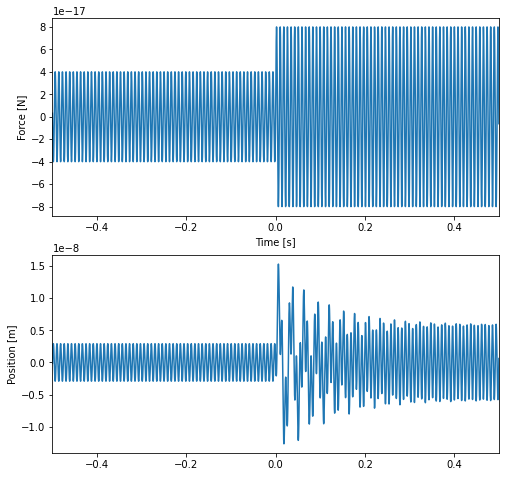

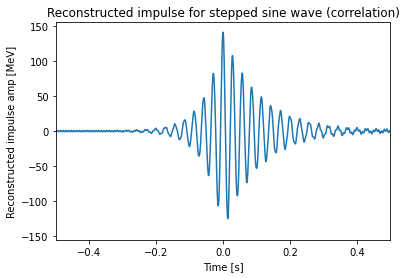

In [91]:
## Now the stepped sine wave
x = reconstructed_position(Ftime)
xcorr = correlation_recon(x)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.title("Reconstructed impulse for stepped sine wave (correlation)")
plt.show()

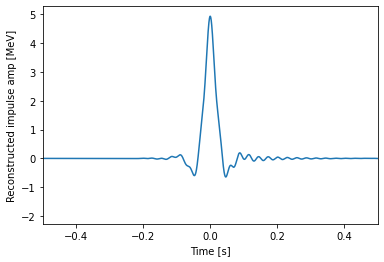

In [92]:
## Now the stepped (and filtered) sine wave
ffilt = 50
b, a = sp.butter(3, ffilt/(2*Fs), btype="lowpass")
xfilt = sp.filtfilt(b,a,x)
xcorr = correlation_recon(xfilt)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.show()

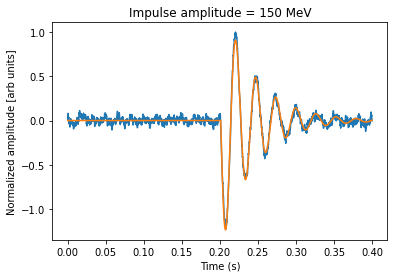

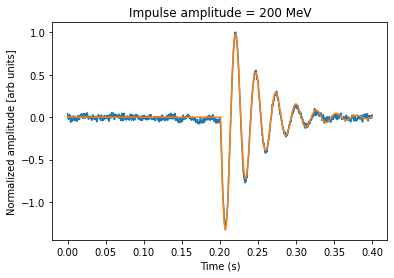

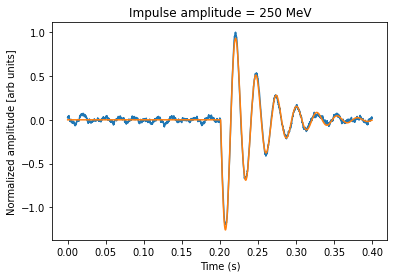

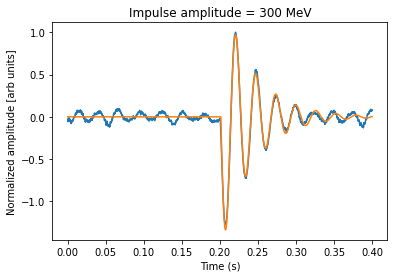

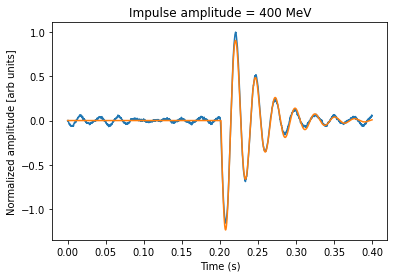

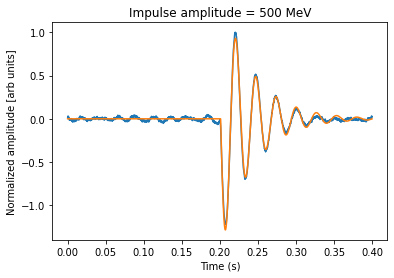

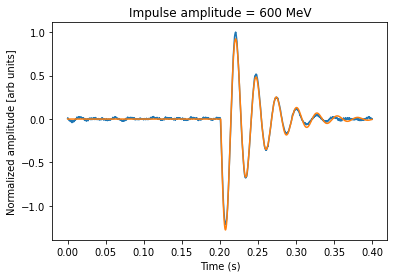

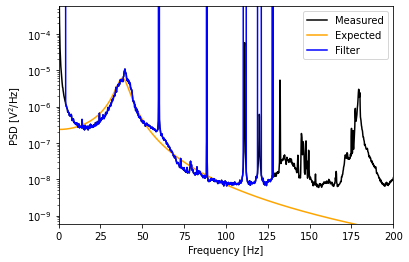

In [93]:
## process with the actual fitler
base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
calib_path = ["20230912/Dx-0.3/impulse_calibration/D-0.3",]
noise_path = ["20230912/Dx-0.3/noise/3",]

## make a list of all the calibration files and sort by impulse size
calib_file_dict = {}
for curr_path in calib_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

noise_file_list = []
for curr_path in noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list


template_dict, template_dict_fit, fit_vals = bu.get_average_template(calib_file_dict, make_plots=True, fit_pars=[-1,2*np.pi*30,10,0.20])
res_pars = [np.median(fit_vals[:,1]), np.median(fit_vals[:,3])]
noise_dict = bu.get_noise_template(noise_file_list, res_pars=res_pars, nfft=2**16)



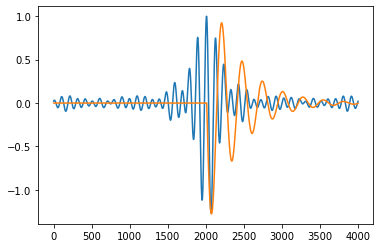

In [94]:
curr_template = template_dict_fit[600.0]
stilde = np.fft.rfft(curr_template)
sfreq = np.fft.rfftfreq(len(curr_template),d=1e-4)
J = np.interp(sfreq, noise_dict['freq'], noise_dict['J'])

bpts = (sfreq < 5) | (sfreq > 100)
J[bpts] = 1e20
phi = stilde/J

phi_t = np.fft.irfft(phi)
phi_t = phi_t/np.max(phi_t)

plt.figure()
plt.plot(phi_t)
plt.plot(curr_template)
plt.show()

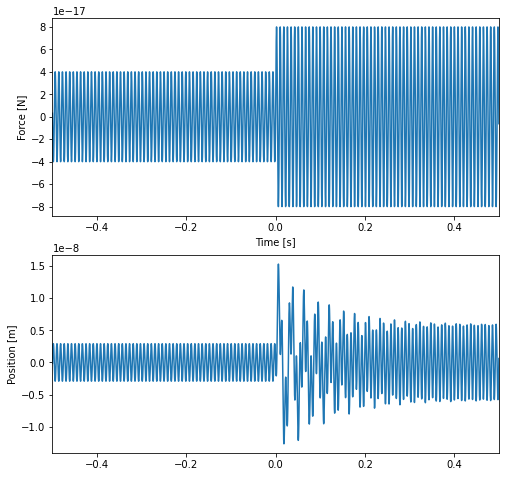

In [95]:
x = reconstructed_position(Ftime)
corr_data_sine = np.abs(sp.correlate(x, phi_t, mode='same'))

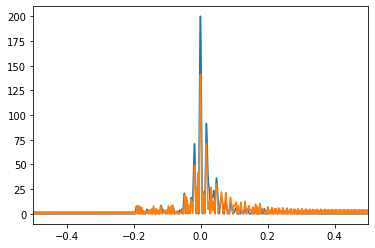

In [96]:
x = amp*np.exp(-gamma*(tvec-t0))*(np.sin(omega1*(tvec-t0)))
x[tvec < t0] = 0

corr_data = np.abs(sp.correlate(x, phi_t, mode='same'))

gpts = (tvec-t0 > -0.5) & (tvec -t0 < 0.5)
sfac = p0/np.max(corr_data[gpts]) * 1/kgms_to_MeV #calibrate to the expected impulse size

plt.figure()
plt.plot(tvec-t0, corr_data*sfac)
plt.plot(tvec-t0, corr_data_sine*sfac)
plt.xlim(-0.5, 0.5)
plt.show()